In [2]:
import torch
torch.manual_seed(0)
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
from torchvision import transforms
from IPython.display import display
import PIL
from PIL import ImageFilter

In [3]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def preprocess_image(image):
    image = (image - mean) / std
    image = np.expand_dims(image, axis=0).transpose(0,3,1,2)
    return torch.Tensor(image)

def deprocess_image(tensor):
    tensor = ((tensor * std) + mean)
    tensor = np.uint8(tensor * 255.0)
    return PIL.Image.fromarray(tensor)

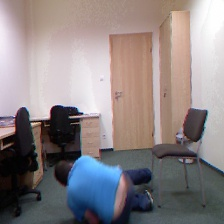

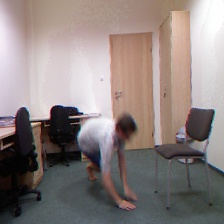

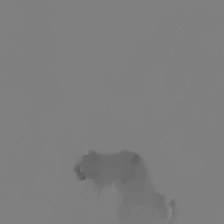

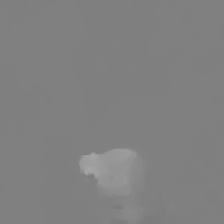

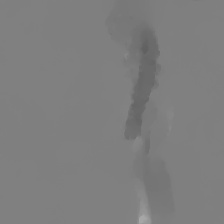

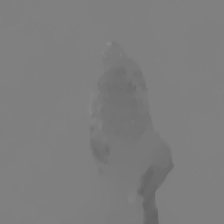

In [4]:
test_path1 = "./frame0068.jpg"
test_path2 = "./frame0100.jpg"
test_path3 = "./flow_x_00024.jpg"
test_path4 = "./flow_y_00024.jpg"
test_path5 = "./flow_x_00004.jpg"
test_path6 = "./flow_x_00015.jpg"


TEST_IMAGE1 = PIL.Image.open(test_path1)
TEST_IMAGE2 = PIL.Image.open(test_path2)
TEST_IMAGE3 = PIL.Image.open(test_path3)
TEST_IMAGE4 = PIL.Image.open(test_path4)
TEST_IMAGE5 = PIL.Image.open(test_path5)
TEST_IMAGE6 = PIL.Image.open(test_path6)
test_image_holder = []
test_image_holder_fake = [TEST_IMAGE1, TEST_IMAGE2, TEST_IMAGE3, TEST_IMAGE4, TEST_IMAGE5, TEST_IMAGE6]

for image in test_image_holder_fake:
    image = image.convert("RGB")
    test_image_holder.append(image)



display(TEST_IMAGE1)
display(TEST_IMAGE2)
display(TEST_IMAGE3)
display(TEST_IMAGE4)
display(TEST_IMAGE5)
display(TEST_IMAGE6)

In [135]:
preprocessed_holder = []
for image in test_image_holder:
    preprocessed_image = preprocess_image(np.asarray(image)/255.0)
    preprocessed_holder.append(preprocessed_image)
    

In [136]:
model = models.vgg16(pretrained=True)
model.eval()
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [137]:
class ActivationsExtractor():
    
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
        
    def hook_fn(self, module, input, output):
        self.features = output

In [138]:
layer = list(model.children())[-2] # last non-output layer
print(layer)

AdaptiveAvgPool2d(output_size=(7, 7))


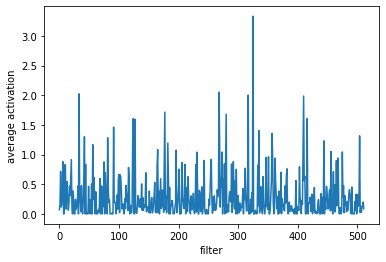

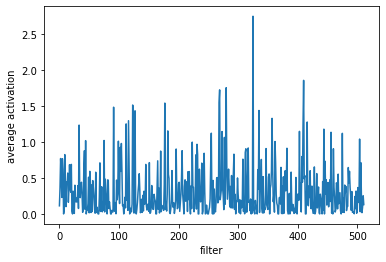

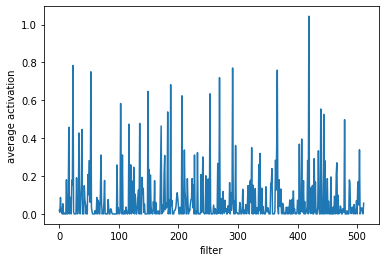

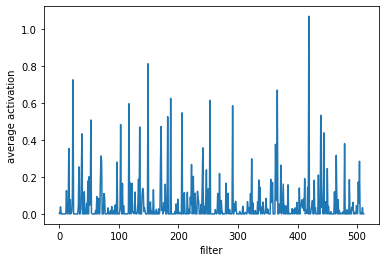

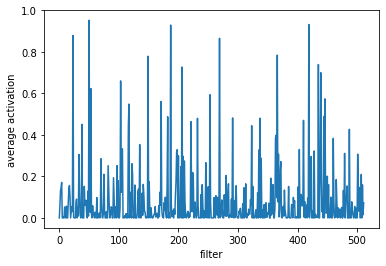

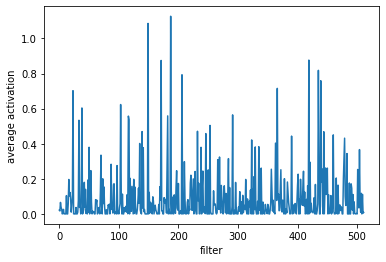

[325, 325, 419, 419, 50, 187]


In [139]:
most_activated_filter_idx_holder = []
for image in preprocessed_holder:
    activations = ActivationsExtractor(layer) # activations' hook
    _ = model(image) # forward pass to collect activations
    average_activations_per_filters = [activations.features[0, i].mean().item() for i in range(activations.features.shape[1])]
    fig = plt.plot(average_activations_per_filters)
    ax = fig[0].axes
    ax.set_xlabel("filter")
    ax.set_ylabel("average activation")
    plt.show()
    most_activated_filter_idx = np.argmax(average_activations_per_filters)
    most_activated_filter_idx_holder.append(most_activated_filter_idx)
    
print(most_activated_filter_idx_holder)

In [140]:
def visualize(filter_num, lr, steps, size, upscales, upscale_factor):
    
    img = np.uint8(np.random.uniform(0, 1, (size, size, 3)))
    for _ in range(upscales):

        img_var = preprocess_image(img).clone().detach().requires_grad_(True)
        optimizer = torch.optim.Adam([img_var], lr=lr, weight_decay=1e-6)

        for _ in range(steps):
            optimizer.zero_grad()
            model(img_var)
            loss = -activations.features[0, filter_num].mean()
            loss.backward()
            optimizer.step()

        img = deprocess_image(img_var.data.cpu().numpy()[0].transpose(1,2,0))

        display(img)

        size = int(upscale_factor * size) 
        img = img.resize((size, size)) 
        img = img.filter(ImageFilter.BLUR)
        img = np.asarray(img) / 255.0

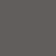

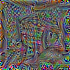

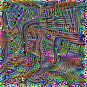

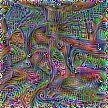

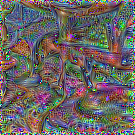

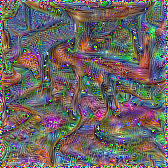

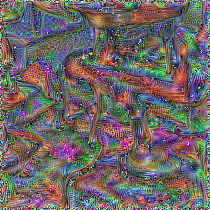

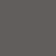

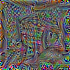

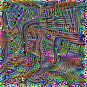

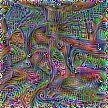

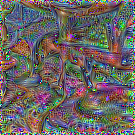

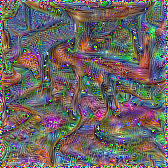

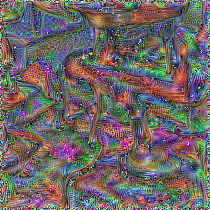

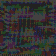

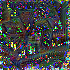

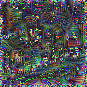

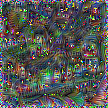

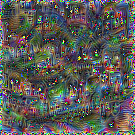

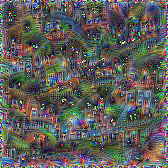

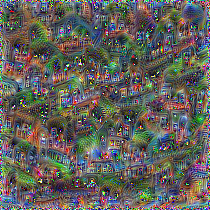

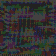

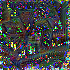

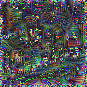

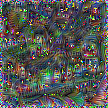

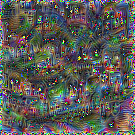

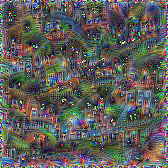

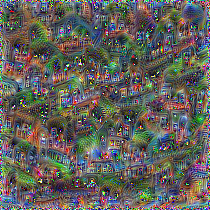

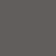

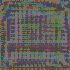

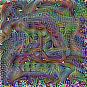

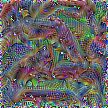

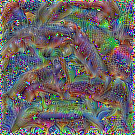

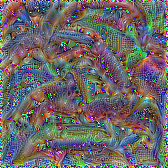

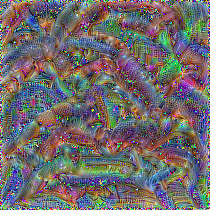

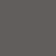

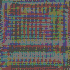

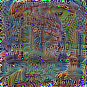

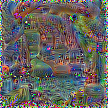

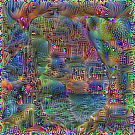

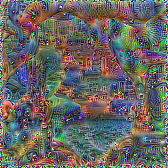

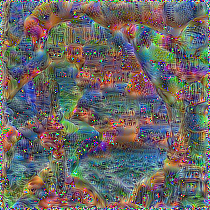

In [141]:
for filter_num in most_activated_filter_idx_holder:
    visualize(filter_num = filter_num, 
              lr=0.075,
              size=56,
              steps=25,
              upscales=7,
              upscale_factor=1.25)